<a href="https://colab.research.google.com/github/maulanawirawan/Periodontal-Diseases/blob/main/periodontal_disease_CLASSIFICATION_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.preprocessing import image
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

# ADDITIONAL
import zipfile
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from keras.models import load_model

from tensorflow import keras

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/FULL DATASET/train'
train_INFLAMMATION_dir = '/content/drive/MyDrive/FULL DATASET/train/inflammation'
train_NORMAL_dir = '/content/drive/MyDrive/FULL DATASET/train/normal'

validation_dir = '/content/drive/MyDrive/FULL DATASET/val'
validation_INFLAMMATION_dir = '/content/drive/MyDrive/FULL DATASET/val/inflammation'
validation_NORMAL_dir = '/content/drive/MyDrive/FULL DATASET/val/normal'

test_dir = '/content/drive/MyDrive/FULL DATASET/test'
test_INFLAMMATION_dir = '/content/drive/MyDrive/FULL DATASET/test/inflammation'
test_NORMAL_dir = '/content/drive/MyDrive/FULL DATASET/test/normal'

In [ ]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [ ]:
train_INFLAMMATION_num = num_files_in_direcotry(train_INFLAMMATION_dir)
train_NORMAL_num = num_files_in_direcotry(train_NORMAL_dir)
train_SUM_num = train_INFLAMMATION_num + train_NORMAL_num

print("[Train] Number of INFLAMMATION Images: ", train_INFLAMMATION_num)
print("[Train] Number of NORMAL Images: ", train_NORMAL_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

validation_INFLAMMATION_num = num_files_in_direcotry(validation_INFLAMMATION_dir)
validation_NORMAL_num = num_files_in_direcotry(validation_NORMAL_dir)
validation_SUM_num = validation_INFLAMMATION_num + validation_NORMAL_num

print("[Val] Number of INFLAMMATION Images: ", validation_INFLAMMATION_num)
print("[Val] Number of NORMAL Images: ", validation_NORMAL_num)
print("[Val] Number of TOTAL Images: ", validation_SUM_num)

test_INFLAMMATION_num = num_files_in_direcotry(test_INFLAMMATION_dir)
test_NORMAL_num = num_files_in_direcotry(test_NORMAL_dir)
test_SUM_num = test_INFLAMMATION_num + test_NORMAL_num

print("[test] Number of INFLAMMATION Images: ", test_INFLAMMATION_num)
print("[test] Number of NORMAL Images: ", test_NORMAL_num)
print("[test] Number of TOTAL Images: ", test_SUM_num)


total_SUM_num = train_SUM_num + validation_SUM_num + test_SUM_num

print(" Total Semua file dalam dataset: ", total_SUM_num)

[Train] Number of INFLAMMATION Images:  131
[Train] Number of NORMAL Images:  100
[Train] Number of TOTAL Images:  231
[Val] Number of INFLAMMATION Images:  28
[Val] Number of NORMAL Images:  16
[Val] Number of TOTAL Images:  44
[test] Number of INFLAMMATION Images:  28
[test] Number of NORMAL Images:  16
[test] Number of TOTAL Images:  44
 Total Semua file dalam dataset:  319


### Convolutional Neural Network

In [ ]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics

    """

    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']

    ## Define train & validation accuracy
    train_auc = cnn_model.history['accuracy']
    val_auc = cnn_model.history['val_accuracy']

    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]

    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))

    ## PLOT 1: TRAIN VS. VALIDATION LOSS
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['INFLAMMATION', 'NORMAL']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)
    #plt.savefig('cm.png', transparent=True)

    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)

    ## END PLOTS
    plt.tight_layout()

    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [ ]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir):

    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, validation_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (256,256),
                                         batch_size = 4,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)

    return generator_lst

# PILIH SALAH SATU ORI ( TANPA AUGMENTATION ). KALAU AKU TADI DENGAN AUGMENTATION VAL_LOSS OVERFITTING KARENA DATASET TERLALU KECIL JADI MACHINE SUSAH MEMBEDAKAN DATASETNYA

In [ ]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 231 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


# PILIH SALAH SATU MODIFY ( DENGAN AUGMENTATION )

In [ ]:
# Load the images

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

# PILIH SALAH SATU ORI ( BAWAAN PROJECT LAMA )

In [ ]:
# CNN model
model = keras.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Flatten(),

            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [ ]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

<ipython-input-11-b6a6d14be9f0>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/30
58/58 [==============================] - 188s 3s/step - loss: 0.7015 - accuracy: 0.5541 - val_loss: 0.6777 - val_accuracy: 0.6364
Epoch 2/30
58/58 [==============================] - 2s 26ms/step - loss: 0.6793 - accuracy: 0.5758 - val_loss: 0.6398 - val_accuracy: 0.6364
Epoch 3/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6573 - accuracy: 0.6147 - val_loss: 0.6202 - val_accuracy: 0.6364
Epoch 4/30
58/58 [==============================] - 2s 27ms/step - loss: 0.6493 - accuracy: 0.7143 - val_loss: 0.6083 - val_accuracy: 0.6364
Epoch 5/30
58/58 [==============================] - 1s 25ms/step - loss: 0.6297 - accuracy: 0.6840 - val_loss: 0.5669 - val_accuracy: 0.7045
Epoch 6/30
58/58 [==============================] - 2s 26ms/step - loss: 0.5848 - accuracy: 0.7056 - val_loss: 0.5366 - val_accuracy: 0.7955
Epoch 7/30
58/58 [==============================] - 2s 27ms/step - loss: 0.5004 - accuracy: 0.7835 - val_loss: 0.5041 - val_accuracy: 0.8182
Epoch 8/30
58

<ipython-input-13-9d24ba1514e4>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 90.91% | Precision = 100.00% | Recall = 85.71% | Specificity = 100.00% | F1 Score = 92.31%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


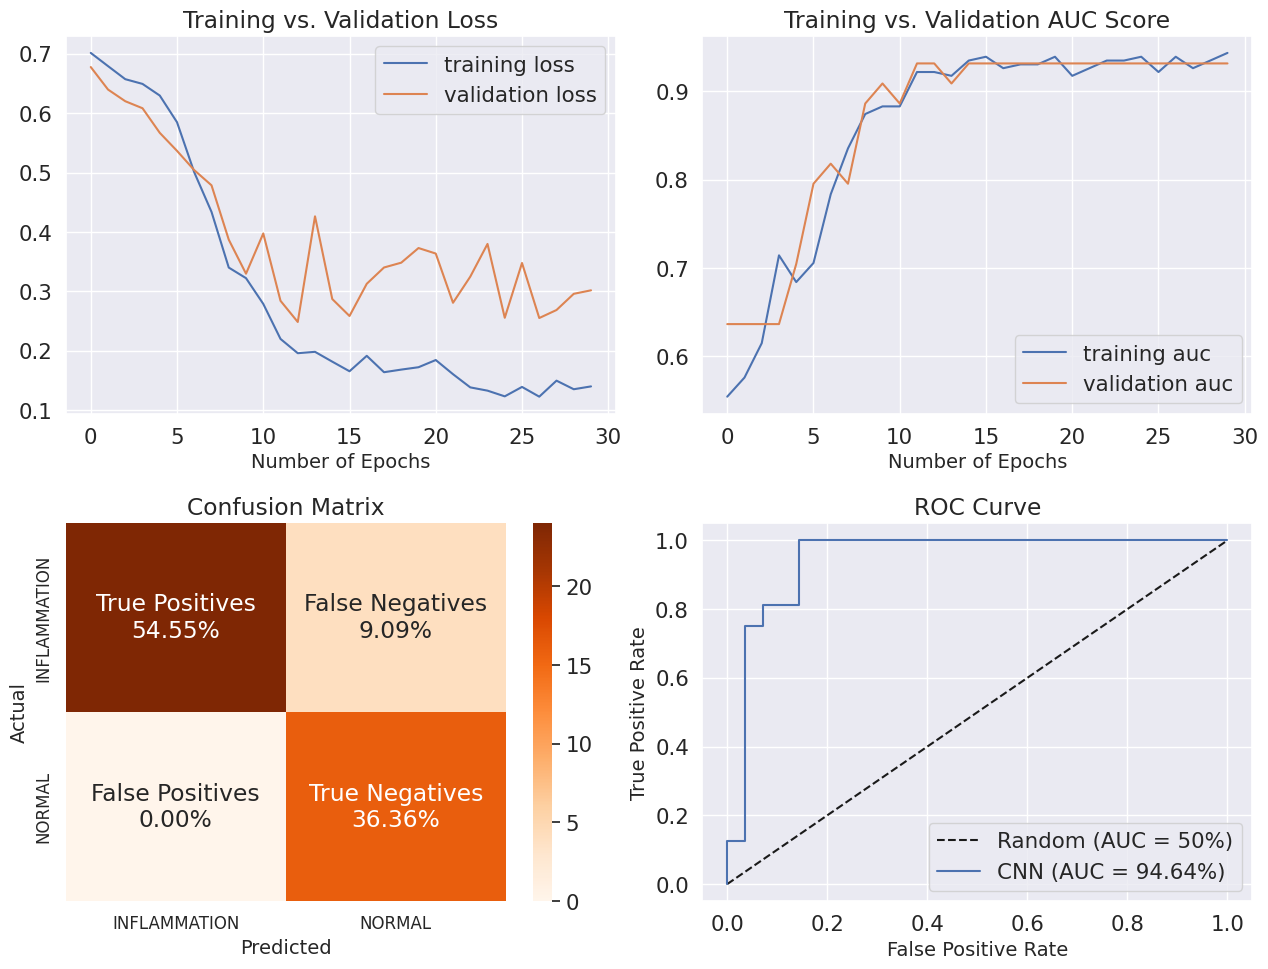

In [ ]:
create_charts(model,cnn_model)
model.save('/model/cnn.h5')

1/1 [==============================] - 0s 74ms/step


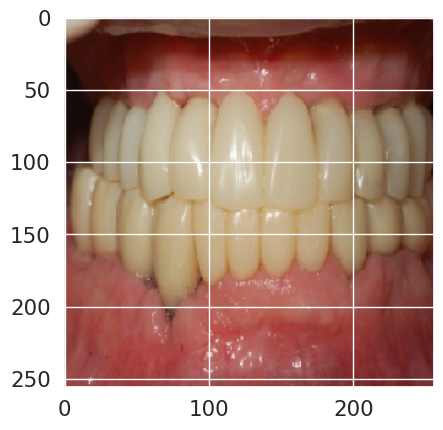

Gambar ini diprediksi sebagai 'INFLAMMATION' dengan probabilitas 99.30%


In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load model yang telah disimpan
model = load_model('/model/cnn.h5')

# Fungsi untuk memprediksi gambar
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

    # Mengubah bentuk menjadi (1, 256, 256, 3)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # Prediksi gambar
    prediction = model.predict(img_tensor)
    return prediction

# Test path
test_path = "/content/drive/MyDrive/FULL DATASET/test/inflammation/n00000003_000177.jpg"

# Prediksi gambar
prediction = predict_image(test_path)

# Tampilkan gambar
img = image.load_img(test_path, target_size=(256, 256))
plt.imshow(img)
plt.show()

# Tampilkan hasil prediksi
if prediction < 0.5:
    print("Gambar ini diprediksi sebagai 'INFLAMMATION' dengan probabilitas {:.2%}".format(1 - prediction[0][0]))
else:
    print("Gambar ini diprediksi sebagai 'NORMAL' dengan probabilitas {:.2%}".format(prediction[0][0]))

In [ ]:
print(train_generator.class_indices)


{'inflammation': 0, 'normal': 1}


# PILIH SALAH SATU PART 2 ( LEBIH KOMPLEKS DAN BERAT )

In [ ]:
# CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    #keras.layers.Dropout(0.5),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
# Train the model

cnn_model = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=2,
    callbacks=[es])

<ipython-input-6-9d24ba1514e4>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 90.91% | Precision = 91.30% | Recall = 84.00% | Specificity = 95.12% | F1 Score = 87.50%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


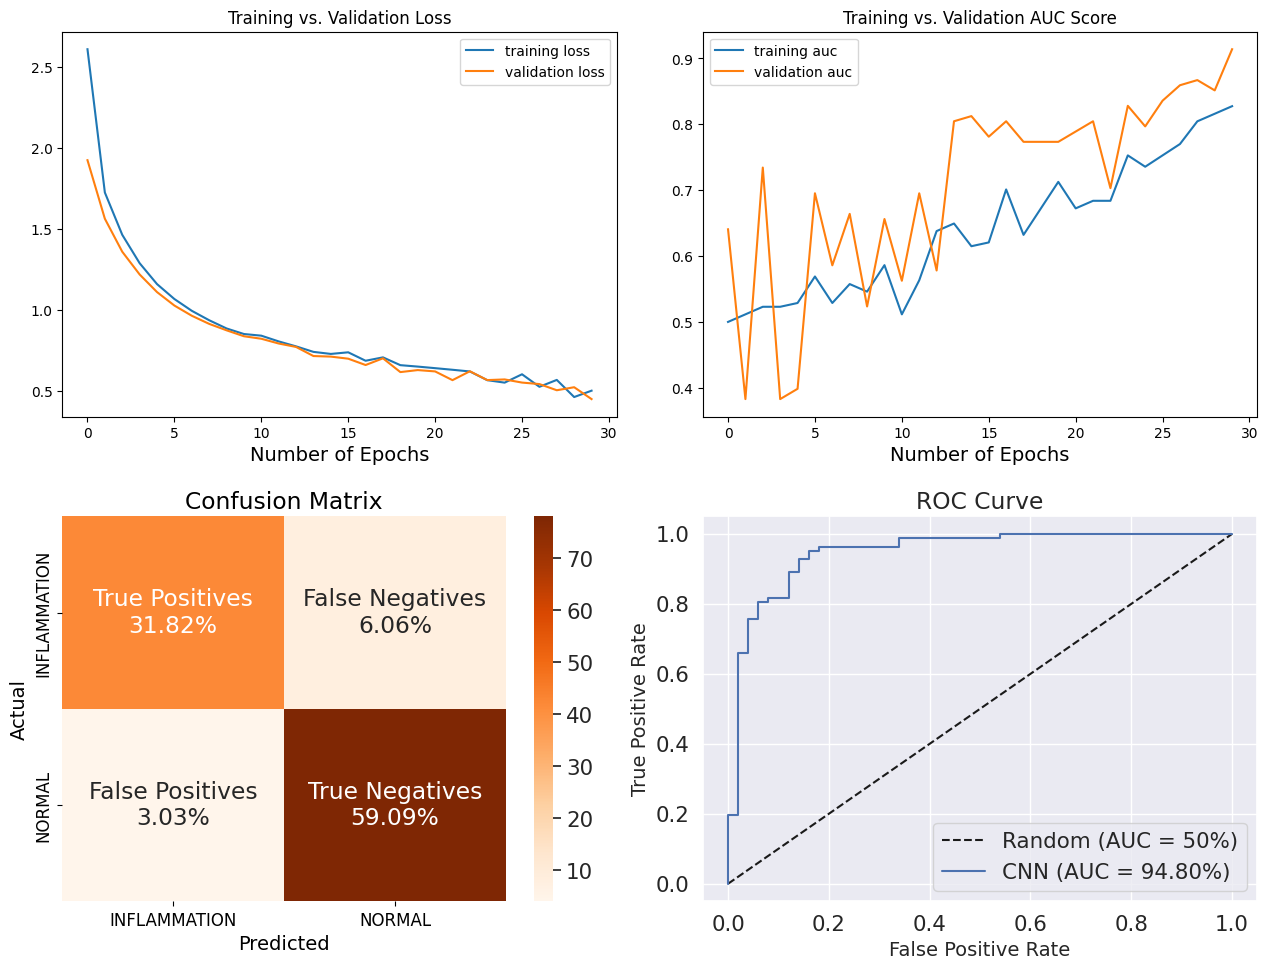

In [ ]:
create_charts(model,cnn_model)
model.save('/model/cnn.h5')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/model/cnn1.h5')

# Continue training
cnn_model = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    callbacks=[es])

Epoch 1/30
17/17 [==============================] - 33s 2s/step - loss: 1.4588 - accuracy: 0.6439 - val_loss: 1.4657 - val_accuracy: 0.6364
Epoch 2/30
17/17 [==============================] - 31s 2s/step - loss: 1.3901 - accuracy: 0.6439 - val_loss: 1.4150 - val_accuracy: 0.6364
Epoch 3/30
17/17 [==============================] - 30s 2s/step - loss: 1.3401 - accuracy: 0.7273 - val_loss: 1.3646 - val_accuracy: 0.6364
Epoch 4/30
17/17 [==============================] - 31s 2s/step - loss: 1.3017 - accuracy: 0.6667 - val_loss: 1.3262 - val_accuracy: 0.6364
Epoch 5/30
17/17 [==============================] - 32s 2s/step - loss: 1.2500 - accuracy: 0.6364 - val_loss: 1.2868 - val_accuracy: 0.6136
Epoch 6/30
17/17 [==============================] - 31s 2s/step - loss: 1.2163 - accuracy: 0.6591 - val_loss: 1.2569 - val_accuracy: 0.5909
Epoch 7/30
17/17 [==============================] - 31s 2s/step - loss: 1.2025 - accuracy: 0.6591 - val_loss: 1.2232 - val_accuracy: 0.5909
Epoch 8/30
17/17 [==

<ipython-input-3-125658e473cf>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 65.91% | Precision = 70.97% | Recall = 78.57% | Specificity = 43.75% | F1 Score = 74.58%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


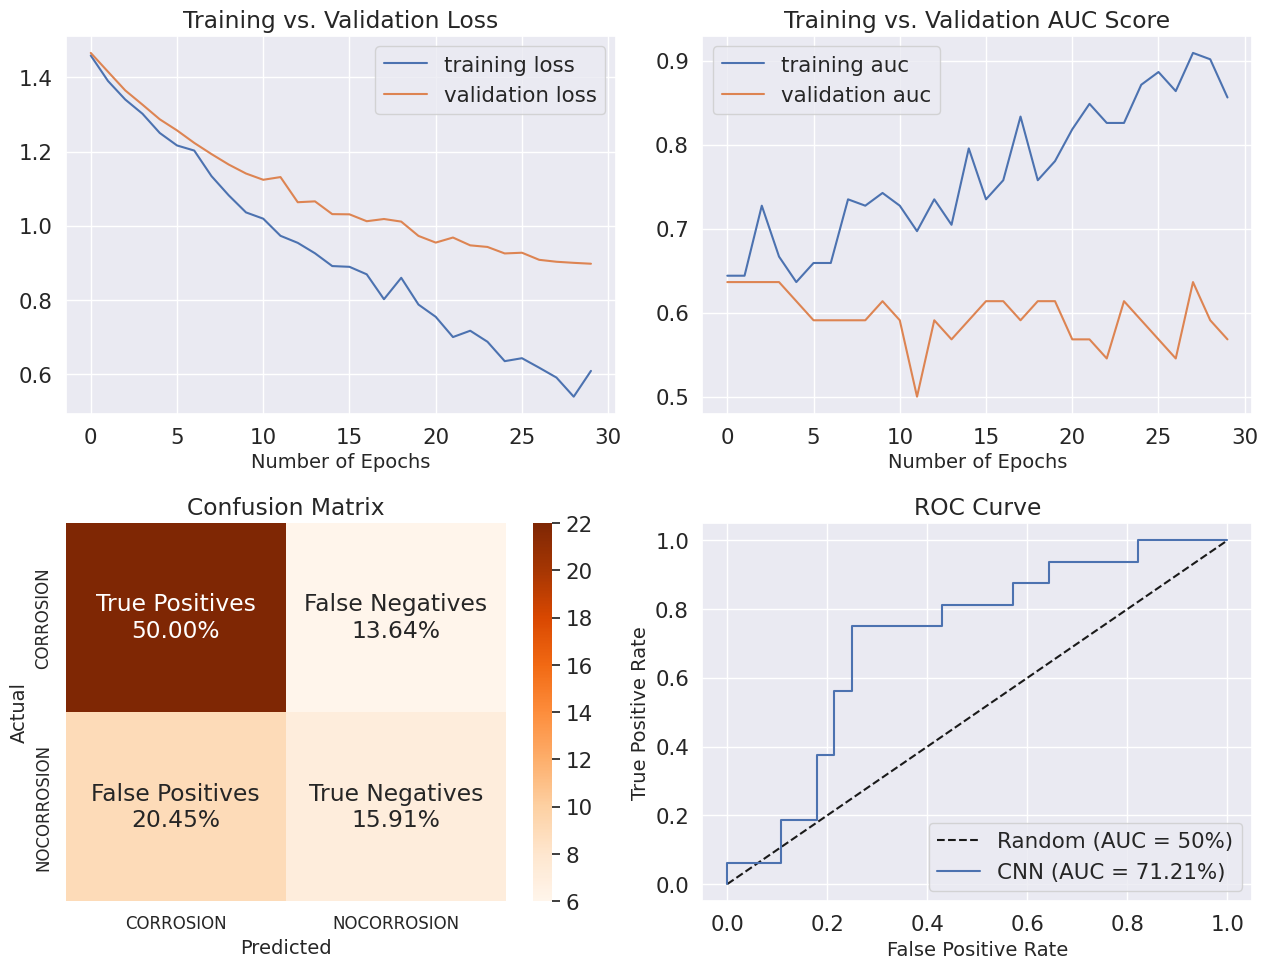

In [ ]:
create_charts(model,cnn_model)
model.save('/model/cnn2.h5')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/model/cnn2.h5')

# Continue training
cnn_model = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    callbacks=[es])

Epoch 1/30
17/17 [==============================] - 34s 2s/step - loss: 0.5357 - accuracy: 0.8636 - val_loss: 0.8777 - val_accuracy: 0.6364
Epoch 2/30
17/17 [==============================] - 43s 2s/step - loss: 0.6189 - accuracy: 0.8485 - val_loss: 0.9154 - val_accuracy: 0.6136
Epoch 3/30
17/17 [==============================] - 34s 2s/step - loss: 0.5036 - accuracy: 0.8712 - val_loss: 0.9042 - val_accuracy: 0.5682
Epoch 4/30
17/17 [==============================] - 30s 2s/step - loss: 0.5082 - accuracy: 0.9167 - val_loss: 0.8842 - val_accuracy: 0.6364
Epoch 5/30
17/17 [==============================] - 31s 2s/step - loss: 0.4927 - accuracy: 0.8939 - val_loss: 0.8655 - val_accuracy: 0.6818
Epoch 6/30
17/17 [==============================] - 31s 2s/step - loss: 0.4473 - accuracy: 0.9242 - val_loss: 0.8993 - val_accuracy: 0.6364
Epoch 7/30
17/17 [==============================] - 30s 2s/step - loss: 0.4509 - accuracy: 0.9242 - val_loss: 0.8822 - val_accuracy: 0.6364
Epoch 8/30
17/17 [==

In [ ]:
create_charts(model,cnn_model)
model.save('/model/cnn3.h5')

# PILIH SALAH SATU PART 3 ( SEDIKIT LEBIH RINGAN KARENA LAYER DIKIT )

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
# Train the model

cnn_model = model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    callbacks=[es])

In [ ]:
create_charts(model,cnn_model)
model.save('/model/cnn1.h5')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/model/cnn1.h5')

# Continue training
cnn_model = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1,
    callbacks=[es])

# PILIH SALAH SATU PT.4 ( VGG16 VERSION )

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Set the path to your dataset
data_dir = './resize_data'


# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18909249 (72.13 MB)
Trainable params: 4194561 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
__________

In [ ]:
# Train the model

cnn_model = model.fit_generator(train_generator,
                              epochs = 15,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

<ipython-input-11-ed3012fa2ac0>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = model.fit_generator(train_generator,


Epoch 1/15
17/17 [==============================] - 145s 8s/step - loss: 2.4050 - accuracy: 0.5455 - val_loss: 2.3445 - val_accuracy: 0.6364
Epoch 2/15
17/17 [==============================] - 136s 8s/step - loss: 1.0501 - accuracy: 0.6970 - val_loss: 0.8178 - val_accuracy: 0.6364
Epoch 3/15
17/17 [==============================] - 125s 7s/step - loss: 0.4885 - accuracy: 0.7727 - val_loss: 0.7371 - val_accuracy: 0.6364
Epoch 4/15
17/17 [==============================] - 138s 8s/step - loss: 0.5100 - accuracy: 0.7576 - val_loss: 0.8145 - val_accuracy: 0.6364
Epoch 5/15
17/17 [==============================] - 124s 7s/step - loss: 0.4236 - accuracy: 0.7348 - val_loss: 0.6525 - val_accuracy: 0.6818
Epoch 6/15
17/17 [==============================] - 126s 8s/step - loss: 0.3903 - accuracy: 0.8409 - val_loss: 0.7004 - val_accuracy: 0.5455
Epoch 7/15
17/17 [==============================] - 133s 8s/step - loss: 0.4257 - accuracy: 0.7652 - val_loss: 0.6976 - val_accuracy: 0.6364
Epoch 8/15
17

<ipython-input-6-9d24ba1514e4>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 70.45% | Precision = 68.29% | Recall = 100.00% | Specificity = 18.75% | F1 Score = 81.16%


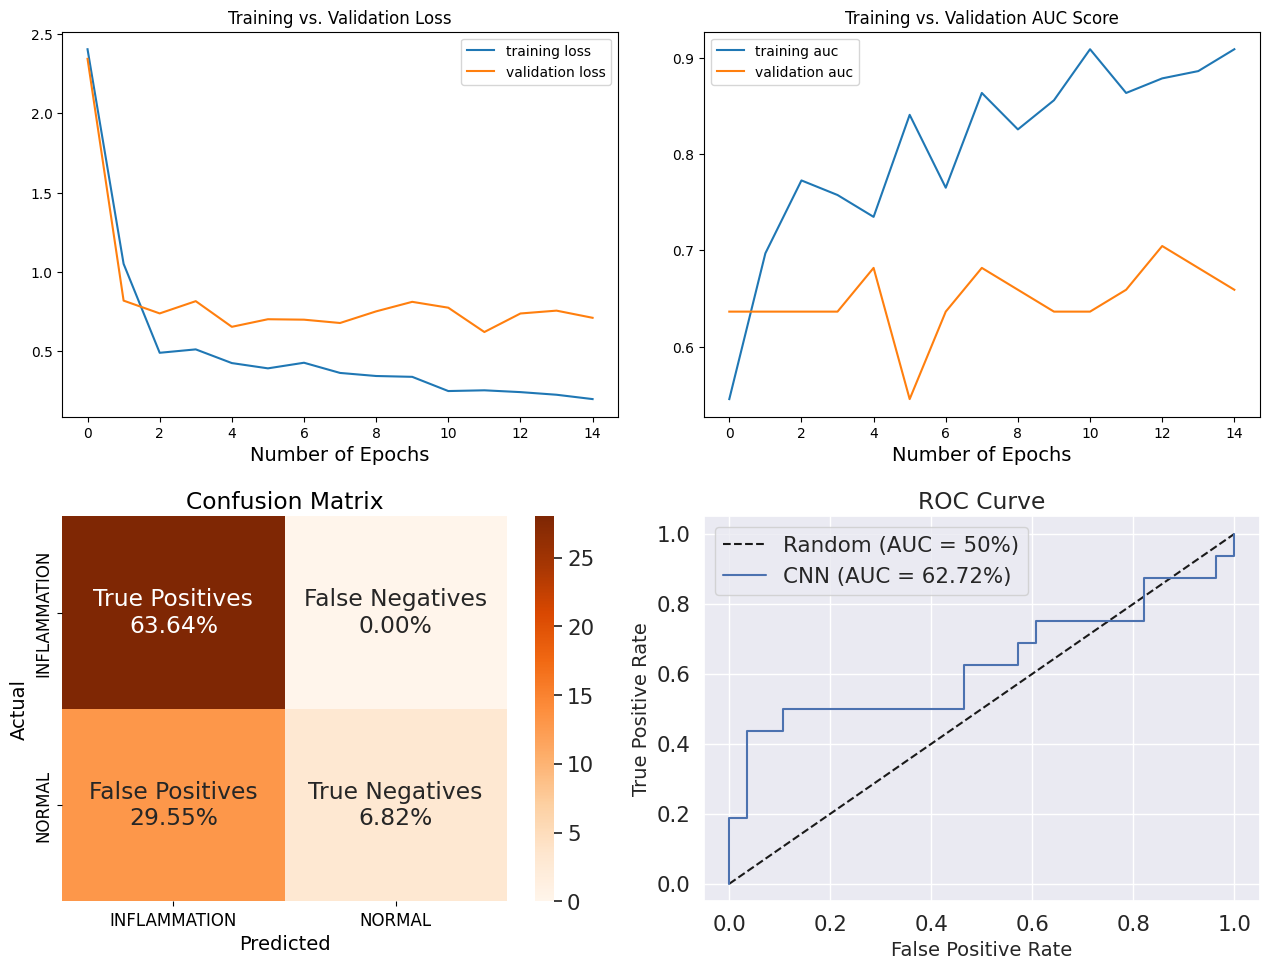

In [ ]:
create_charts(model,cnn_model)